In [325]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [326]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os


In [327]:
bd = '/Users/Isaac/box/Kitzman_lab/data/20180622_WT.vs.A636P/'

In [328]:
# function that converts clusterBc file top 90% barcodes to a list of barcodes as barcode library. 
def bc_90ile(clusterBC_file):
    fh = open (clusterBC_file, 'r')
    bc_total=0
    
    for bc in fh:
        bc_occ = bc.split()[1]
        bc_occ = int(bc_occ)
        bc_total += bc_occ
    fh.close()
    
    bcs = []
    
    bc_counter=0
    line_counter=0
    
    fh = open (clusterBC_file, 'r')
    for line in fh:
        line_counter += 1
        bc_num = line.split()[1]
        bc_num = int(bc_num)
        bc_counter += bc_num
        bc = line.split()[0]
        bcs.append(bc)
        if (bc_counter/np.float64(bc_total)) > (90/100.0):
            break
    return bcs
    fh.close()

In [329]:
wt=bc_90ile(bd+'wt.txt')
wt=set(wt)
a636p=bc_90ile(bd+'A636P.txt')
a636p=set(a636p)
# import pickle
# bc_cat = pickle.load( open(bd+ 'bc_catalog'+'.json', "rb" ) )
# wt, a636p = bc_cat
print len(wt), len (a636p)

5768 3600


<matplotlib_venn._common.VennDiagram instance at 0x12480e320>

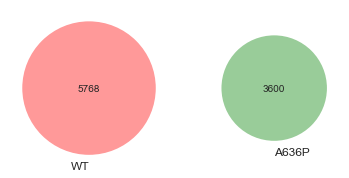

In [330]:
from matplotlib_venn import venn2
venn2([wt, a636p], set_labels = ('WT', 'A636P'))
#at this point the two sets of barcodes have no overlap. Algorithm-wise, either in WT, or A636P, or in PALs

In [331]:
dd = bd+'wt-a636p_venn/'
mock_bcs = bc_90ile(dd+'w2_db.bc_cluster.txt')
db6tg_bcs = bc_90ile(dd+'w5_6TGB.bc_cluster.txt')
bc_all = set(mock_bcs + db6tg_bcs)
print len(mock_bcs), len(db6tg_bcs), len(bc_all)

7179 3406 7635


<matplotlib_venn._common.VennDiagram instance at 0x1299cd440>

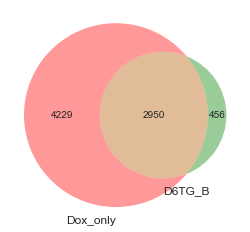

In [332]:
from matplotlib_venn import venn2
venn2([set(mock_bcs), set(db6tg_bcs)], set_labels = ('Dox_only', 'D6TG_B'))

#  this Venn diagram isn't great. as post 6TG treatment barcodes should be a subset of pre-6TG treatment, however, only 50% are

In [333]:
def dict_gen(clusterBC_file):
    dict1 = {}
    fh = open (clusterBC_file, 'r')
    for line in fh:
        dict1[line.split()[0]] = int(line.split()[1])
    return dict1
    fh.close()

In [334]:
col_names = ['w2_db','w5_6TGB']
df = pd.DataFrame(None, index=bc_all, columns = col_names)
df.head()


,w2_db,w5_6TGB
CGTATCATCATCAGGGCATTTGG,NaN,NaN
GTACTTCCTTATAATCACGGTGG,NaN,NaN
CTCGGACCCCGGAAGAAGCTTGG,NaN,NaN
TAAAACGCACCACTGGCTATGG,NaN,NaN
TGAGTTAGAGGCAGCTCCGATGG,NaN,NaN


In [335]:
all_bcfiles = ['w2_db.bc_cluster.txt','w5_6TGB.bc_cluster.txt']

from collections import defaultdict

for fn in all_bcfiles:
    bc_dict = dict_gen(dd+fn)
    col_name = fn[:-15]
    print col_name
    print len(bc_dict)
    for bc_lin in bc_all:
        if bc_lin in bc_dict.keys():
            df.at[bc_lin, col_name] = int(bc_dict[bc_lin])
        else:
            df.at[bc_lin, col_name] = 0

w2_db
13897
w5_6TGB
9593


In [336]:
cutoff=3
df = df[df['w2_db']>cutoff]
# df = df[df['w5_6TGB']>3]

In [337]:
# df = df + 0.5
for bc_lin in bc_all:
    if bc_lin in wt:
        df.at[bc_lin, 'color'] = 'green'
    elif bc_lin in a636p:
        df.at[bc_lin, 'color'] = 'red'
    else: 
        df.at[bc_lin, 'color'] = 'grey'
df = df.dropna()
df.iloc[:,:-1]= df.iloc[:,:-1]+0.1

In [338]:
sum_6TG = df['w5_6TGB'].sum()
sum_mock = df['w2_db'].sum()
df['w5_6TGB_norm'] = df['w5_6TGB']/sum_6TG
df['w2_db_norm'] = df['w2_db']/sum_mock
df.head()

,w2_db,w5_6TGB,color,w5_6TGB_norm,w2_db_norm
CGTATCATCATCAGGGCATTTGG,43.1,67.1,red,0.000949254,0.000663883
GTACTTCCTTATAATCACGGTGG,9.1,2.1,green,2.97084e-05,0.00014017
TGAGTTAGAGGCAGCTCCGATGG,4.1,0.1,green,1.41469e-06,6.31536e-05
GATCAGGGCAAGATCTTTTATGG,11.1,0.1,red,1.41469e-06,0.000170977
TGGGCGGGATGATCATGTGCTGG,4.1,25.1,red,0.000355086,6.31536e-05


In [339]:
# df

In [340]:
df1 = df.copy()
df1['enrich']= df1['w5_6TGB_norm']/df1['w2_db_norm']
df1['enrich_log10']=df1['enrich'].astype(np.float64).apply(log10)
df1.head()

,w2_db,w5_6TGB,color,w5_6TGB_norm,w2_db_norm,enrich,enrich_log10
CGTATCATCATCAGGGCATTTGG,43.1,67.1,red,0.000949254,0.000663883,1.42985,0.155291
GTACTTCCTTATAATCACGGTGG,9.1,2.1,green,2.97084e-05,0.00014017,0.211945,-0.673776
TGAGTTAGAGGCAGCTCCGATGG,4.1,0.1,green,1.41469e-06,6.31536e-05,0.0224007,-1.649738
GATCAGGGCAAGATCTTTTATGG,11.1,0.1,red,1.41469e-06,0.000170977,0.00827414,-2.082277
TGGGCGGGATGATCATGTGCTGG,4.1,25.1,red,0.000355086,6.31536e-05,5.62258,0.749936


(array([   0.,    0.,    0.,    0.,    0.,    0.,    1.,    2.,    4.,
           5.,    9.,   14.,   14.,   17.,   40.,   46.,   68.,   58.,
          71.,   84.,  114.,  167.,  201.,  238.,    0.,  249.,    0.,
         350.,    0.,    0.,    1.,    0.,    4.,    1.,    3.,    7.,
           4.,   10.,    7.,   12.,   19.,   10.,    6.,   13.,   18.,
          12.,    9.,   21.,    8.,   11.,    4.,    9.,    3.,   18.,
           2.,    4.,    6.,    4.,    2.,    5.,    2.,    4.,    0.,
           0.,    1.,    1.,    0.,    1.,    0.,    1.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.]),
 array([ -3.00000000e+00,  -2.95000000e+00,  -2.90000

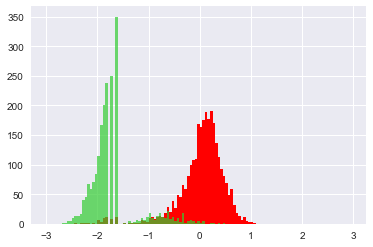

In [341]:
df_a636p1 = df1[df1['color']=='red']
df_wt1 = df1[df1['color']=='green']
df_PALs = df1[df1['color']=='grey']
# hist([df_a636p1['enrich'], df_wt1['enrich']], bins=100, histtype='bar', log=True, color=['r','g'])

plt.hist(df_a636p1['enrich_log10'], bins=np.arange(-3,3,0.05),color='red')
plt.hist(df_wt1['enrich_log10'], bins=np.arange(-3,3,0.05),color='limegreen',alpha = 0.7)
# plt.hist(df_PALs['enrich'], bins=np.logspace(np.log10(0.01),np.log10(100), 30),color='grey')
# plt.gca().set_xscale("log")
# plt.yscale('log')

In [342]:
dfx=df_wt1[df_wt1['enrich_log10']>1]
# dfx=dfx[dfx['enrich_log10']<0]
dfx

,w2_db,w5_6TGB,color,w5_6TGB_norm,w2_db_norm,enrich,enrich_log10


In [343]:
df2 = df1.copy()
df2['enrich_log10']=df2['enrich'].astype(np.float64).apply(log10)
df2.head()

,w2_db,w5_6TGB,color,w5_6TGB_norm,w2_db_norm,enrich,enrich_log10
CGTATCATCATCAGGGCATTTGG,43.1,67.1,red,0.000949254,0.000663883,1.42985,0.155291
GTACTTCCTTATAATCACGGTGG,9.1,2.1,green,2.97084e-05,0.00014017,0.211945,-0.673776
TGAGTTAGAGGCAGCTCCGATGG,4.1,0.1,green,1.41469e-06,6.31536e-05,0.0224007,-1.649738
GATCAGGGCAAGATCTTTTATGG,11.1,0.1,red,1.41469e-06,0.000170977,0.00827414,-2.082277
TGGGCGGGATGATCATGTGCTGG,4.1,25.1,red,0.000355086,6.31536e-05,5.62258,0.749936


In [344]:
df2['w5_6TGB_norm_log10']=df2['w5_6TGB_norm'].astype(np.float64).apply(log10)
df2['w2_db_norm_log10']=df2['w2_db_norm'].astype(np.float64).apply(log10)
df2.head()

,w2_db,w5_6TGB,color,w5_6TGB_norm,w2_db_norm,enrich,enrich_log10,w5_6TGB_norm_log10,w2_db_norm_log10
CGTATCATCATCAGGGCATTTGG,43.1,67.1,red,0.000949254,0.000663883,1.42985,0.155291,-3.022618,-3.177909
GTACTTCCTTATAATCACGGTGG,9.1,2.1,green,2.97084e-05,0.00014017,0.211945,-0.673776,-4.527121,-3.853344
TGAGTTAGAGGCAGCTCCGATGG,4.1,0.1,green,1.41469e-06,6.31536e-05,0.0224007,-1.649738,-5.849340,-4.199602
GATCAGGGCAAGATCTTTTATGG,11.1,0.1,red,1.41469e-06,0.000170977,0.00827414,-2.082277,-5.849340,-3.767063
TGGGCGGGATGATCATGTGCTGG,4.1,25.1,red,0.000355086,6.31536e-05,5.62258,0.749936,-3.449666,-4.199602


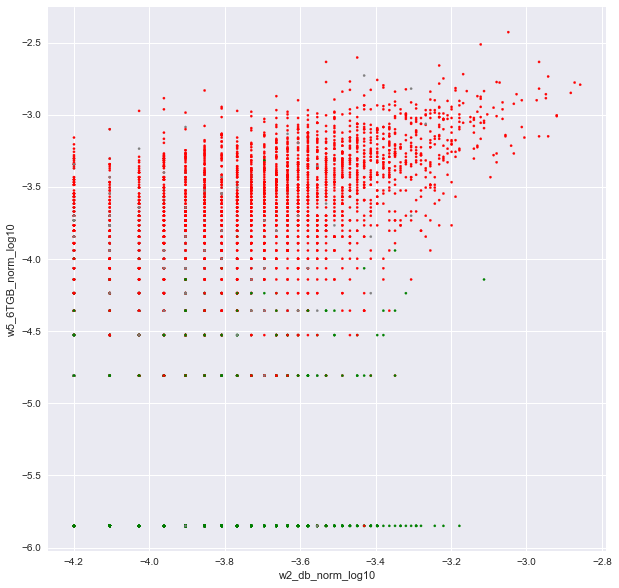

In [345]:
plt.figure(figsize=(10,10))
x = df2['w2_db_norm_log10']
y = df2['w5_6TGB_norm_log10']
xlabel('w2_db_norm_log10')
ylabel('w5_6TGB_norm_log10')
plt.scatter(x,y,c=df2['color'],s=5)
plt.ylim=(-6, 0)
plt.ylim=(-6, 0)


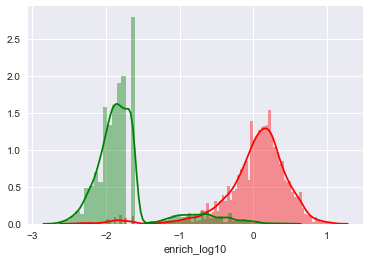

In [346]:

import seaborn as sns
sns.distplot(df_a636p1['enrich_log10'],color='r',bins=100,norm_hist=True)
sns.distplot(df_wt1['enrich_log10'],color='g',bins=50,norm_hist=True)
# sns.distplot(df_pals['enrich_log10'],color='grey',bins=50,norm_hist=True)